In [1]:
import numpy as np
import pandas as pd
import torch
import transformers

import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertForNextSentencePrediction, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

rcParams['figure.figsize'] = 12, 8

In [2]:
RANDOM_SEED = 42
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

DATA_PATH = 'data/similar_book_pairs.csv'
NUM_OF_ITEMS = 100

BATCH_SIZE = 1
NUM_EPOCHS = 5
MAX_SEQUENCE_LENGTH = 256

# Based on the recommended hyperparameters in the BERT paper
DROPOUT_RATE = 0.3
LEARNING_RATE = 3e-5

In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Book pair datasets and dataloaders

In [4]:
book_pairs_df = pd.read_csv(DATA_PATH).dropna()
book_pairs_df = book_pairs_df.head(NUM_OF_ITEMS)
book_pairs_df.head(10)

,pair_id,book1_id,book1_title,book1_description,book2_id,book2_title,book2_description,target_class
0,0,15984348,"X-Men, by Brian Wood, Volume 1: Blank Generation",Superstar writer Brian Wood (Wolverine & the X...,16002124,"Astonishing X-Men, Volume 11: Weaponized",It's the explosive aftermath to the year's mos...,1
1,1,15779244,"1971 (Mark Miller's One, #10)",100% of the author's proceeds will be donated ...,18270710,The Tiger (The Donkey and the Wall #3),"""Lost and found..."" The Tiger chronicles the L...",0
2,2,17338329,"Beware of Bad Boy (Beware of Bad Boy, #1)","**Ebook FREE on Amazon, iTunes, Google Play an...",17611210,The Mistress Mistake,Jessica Conway is at the end of her rope. She ...,1
3,3,32329580,"Fur (Becoming, #1)",Have you ever wondered what it's like to becom...,12434408,"Goodnight, Angels","Goodnight, rubber duckie. Thank you for the sc...",0
4,4,18584581,Exposed,Nia doesn't know why the TV show Dirty Rotten ...,17665070,Unearthing Cole,Cole Alston swore he'd never return to his chi...,0
5,5,30282842,Day Dreamer (Undeadly Secrets Book 2),Alex Hensley thought that discovering vampires...,12042965,Raphael's Mating,[Siren Classic ManLove: Erotic Alternative Par...,0
6,6,417803,"Shooting Chant (Ella Clah, #5)",Navajo Police Special Investigator Ella Clah i...,22022427,When Lines Are Blurred,J2 Fanfic High school au in which Jensen Ackle...,0
7,7,21531497,The Laughing Monsters,Denis Johnson's The Laughing Monsters is a hig...,18490553,American Innovations: Stories,A brilliant new collection of short stories fr...,1
8,8,19462885,"The Adventure Continues (Adventure, #2)",Rose and Ian were a match made in heaven. Or s...,25088474,Senses Series Box Set (Senses #1-5),This box set contains Senses Series Books 1-5....,0
9,9,31867595,Dreaming of Love (The Bradens at Trusty #5; T...,DREAMING OF LOVE is a USA TODAY BESTSELLER Emi...,22031611,Man from the Sky,"For seventy-three-year-old Jaime, the answer t...",0


In [5]:
class SimilarBooksDataset(Dataset):

  def __init__(self, book_pairs_df):
    self.book_pairs_df = book_pairs_df
  
  def __len__(self):
    return len(self.book_pairs_df)
  
  def __getitem__(self, item):
    pair = self.book_pairs_df.iloc[item]
    
    return {
        'book1_sequence': pair["book1_description"],
        'book2_sequence': pair["book2_description"],
        'target_class': 1 - pair['target_class']  # Here we use 1 - target_class because BERT takes class 0 as positive(B is after A) and 1 as negative(B is random)
    }

In [6]:
class SequenceCollate:
    """
    Collate to tokenize and apply the padding to the sequences with dataloader
    """
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    def __call__(self, batch):
        book1_sequences, book2_sequences, target_classes = [], [], []
        for pair in batch:
            book1_sequences.append(pair['book1_sequence'])
            book2_sequences.append(pair['book2_sequence'])
            target_classes.append(pair['target_class'])

        encoded_sequences = self.tokenizer(
            book1_sequences,
            book2_sequences,
            padding='longest',
            truncation='longest_first',
            return_tensors='pt',
            max_length=MAX_SEQUENCE_LENGTH
        )

        return {
            'input_ids': encoded_sequences['input_ids'],
            'attention_mask': encoded_sequences['attention_mask'],
            'token_type_ids': encoded_sequences['token_type_ids'],
            'labels': torch.as_tensor(target_classes, dtype=torch.long)
        }

In [7]:
def create_data_loader(df, batch_size, mode='train'):
    dataset = SimilarBooksDataset(
        book_pairs_df=df
    )

    should_shuffle = mode == 'train'
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        collate_fn=SequenceCollate(),
        shuffle=should_shuffle
    )

In [8]:
df_train, df_test = train_test_split(book_pairs_df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [9]:
print(f'Train shape     : {df_train.shape}')
print(f'Validation shape: {df_val.shape}')
print(f'Test shape      : {df_test.shape}')

Train shape     : (80, 8)
Validation shape: (10, 8)
Test shape      : (10, 8)


In [10]:
train_data_loader = create_data_loader(df_train, BATCH_SIZE, mode='train')
val_data_loader = create_data_loader(df_val, BATCH_SIZE, mode='eval')
test_data_loader = create_data_loader(df_test, BATCH_SIZE, mode='eval')

### Example data

In [11]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels'])

In [12]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['token_type_ids'].shape)
print(data['labels'].shape)

print(f'Target classes: {data["labels"]}')

torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1])
Target classes: tensor([0])


# BERT for book similarity training

In [13]:
model = BertForNextSentencePrediction.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Example forward

In [14]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)
target_classes = data['labels'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq length
print(target_classes.shape) # batch size x 1

torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1])


In [15]:
torch.cuda.empty_cache()
model.train()

outputs = model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    token_type_ids=token_type_ids,
    labels=target_classes
)

print(outputs.loss.detach().item())

0.0008509114268235862


### Actual training

In [16]:
# This setup is recommended for BERT training by the authors
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * NUM_EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [17]:
def train_epoch(model, data_loader, optimizer, scheduler):
    model = model.train()

    losses = []
    correct_predictions = 0
    all_predictions = 0

    progress_bar = tqdm(range(len(data_loader)), position=0, leave=True)
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_masks = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        targets = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_masks,
            labels=targets
        )
        
        loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        losses.append(loss.detach().item())
        
        all_predictions += input_ids.shape[0]
        predicted_classes = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(predicted_classes == targets)

        optimizer.zero_grad()
        progress_bar.update(1)
    
    accuracy = correct_predictions.double() / all_predictions
    return accuracy.detach().item(), np.mean(losses)

In [18]:
def eval_model(model, data_loader):
    model = model.eval()

    losses = []
    correct_predictions = 0
    all_predictions = 0

    progress_bar = tqdm(range(len(data_loader)), position=0, leave=True)
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_masks = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_masks,
                labels=targets
            )

            loss = outputs.loss
            losses.append(loss.detach().item())

            all_predictions += input_ids.shape[0]
            predicted_classes = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(predicted_classes == targets)

            progress_bar.update(1)

    accuracy = correct_predictions.double() / all_predictions
    return accuracy.detach().item(), np.mean(losses)

In [19]:
%%time

history = defaultdict(list)
best_accuracy = 0

torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')
    print('#' * 100)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        optimizer,
        scheduler
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/80 [00:00<?, ?it/s]Epoch 1/5
####################################################################################################
100%|██████████| 10/10 [00:00<00:00, 23.03it/s]
Validation loss 0.6379203431080895 accuracy 0.9

  0%|          | 0/80 [00:00<?, ?it/s]Epoch 2/5
####################################################################################################
  0%|          | 0/80 [00:00<?, ?it/s]Validation loss 0.8211143486390938 accuracy 0.9

Epoch 3/5
####################################################################################################
  0%|          | 0/80 [00:00<?, ?it/s]Validation loss 1.3783887939237502 accuracy 0.8

Epoch 4/5
####################################################################################################
100%|██████████| 10/10 [00:00<00:00, 22.53it/s]
Validation loss 1.3654652805336809 accuracy 0.8

Epoch 5/5
####################################################################################################
 

100%|██████████| 10/10 [00:00<00:00, 24.84it/s]


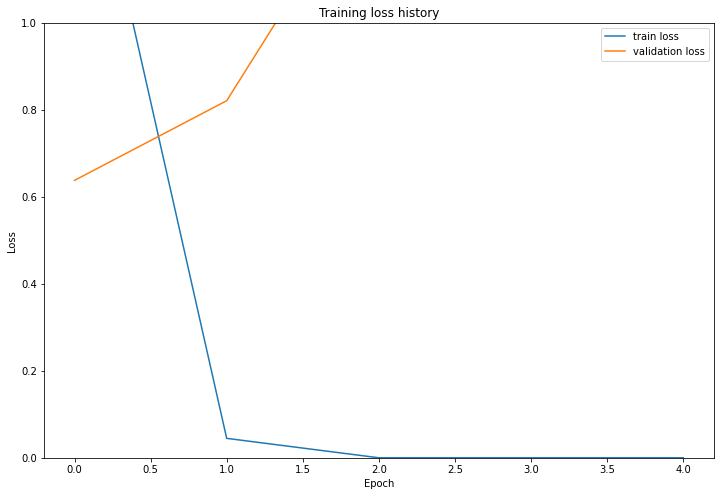

In [20]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

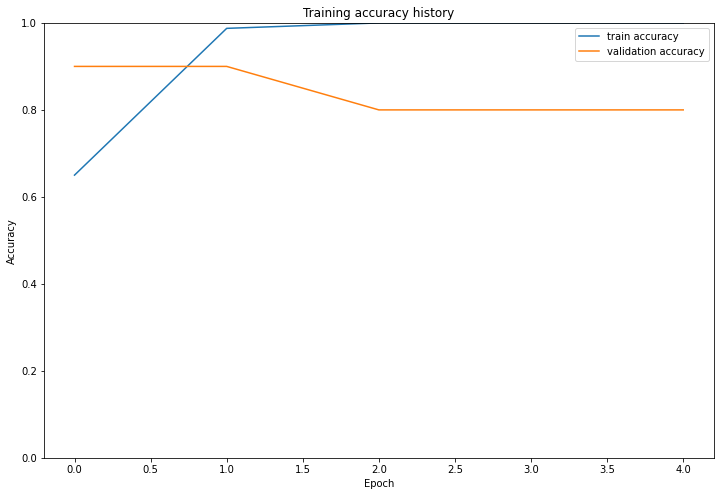

In [21]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training accuracy history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation on test

In [22]:
test_acc, _ = eval_model(
  model,
  test_data_loader
)

print(f'\n\nTest final accuracy: {test_acc}')

 90%|█████████ | 9/10 [00:00<00:00, 26.57it/s]

Test final accuracy: 0.8


In [23]:
def get_predictions(model, data_loader):
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []

  progress_bar = tqdm(range(len(data_loader)), position=0, leave=True)
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      
      preds = torch.argmax(outputs.logits, dim=1)
      probs = F.softmax(outputs.logits, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

      progress_bar.update(1)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return predictions, prediction_probs, real_values

In [24]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

 80%|████████  | 8/10 [00:00<00:00, 30.21it/s]

### Metrics on test

In [25]:
print(classification_report(y_test, y_pred, target_names=['similar', 'non-similar']))

              precision    recall  f1-score   support

     similar       0.83      0.83      0.83         6
 non-similar       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



100%|██████████| 10/10 [00:00<00:00, 21.94it/s]


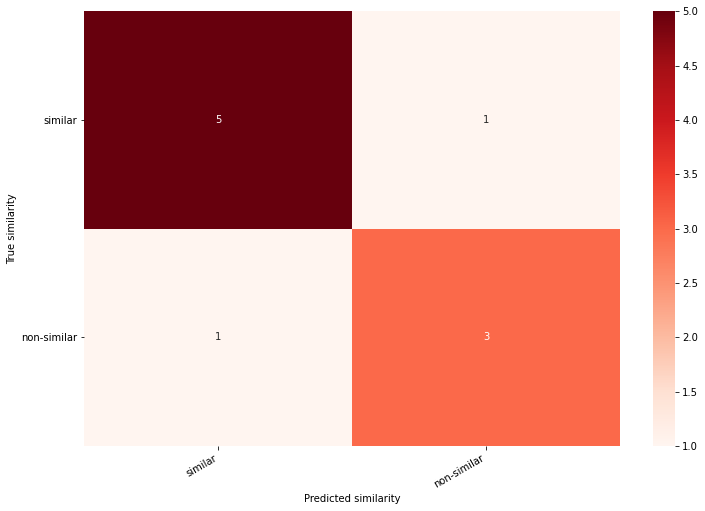

In [26]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True similarity')
  plt.xlabel('Predicted similarity');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['similar', 'non-similar'], columns=['similar', 'non-similar'])
show_confusion_matrix(df_cm)

### Example probs of an item

In [27]:
print(f'True similarity of first example: {y_test[0]} (0 similar, 1 non similar)')
print(f'Predicted similarity of first example: {y_pred[0]} (0 similar, 1 non similar)')
print(f'Predicted probs of first example: similar - {y_pred_probs[0][0]}, non similar - {y_pred_probs[0][1]}')

True similarity of first example: 1 (0 similar, 1 non similar)
Predicted similarity of first example: 1 (0 similar, 1 non similar)
Predicted probs of first example: similar - 0.0002487603633198887, non similar - 0.9997512698173523


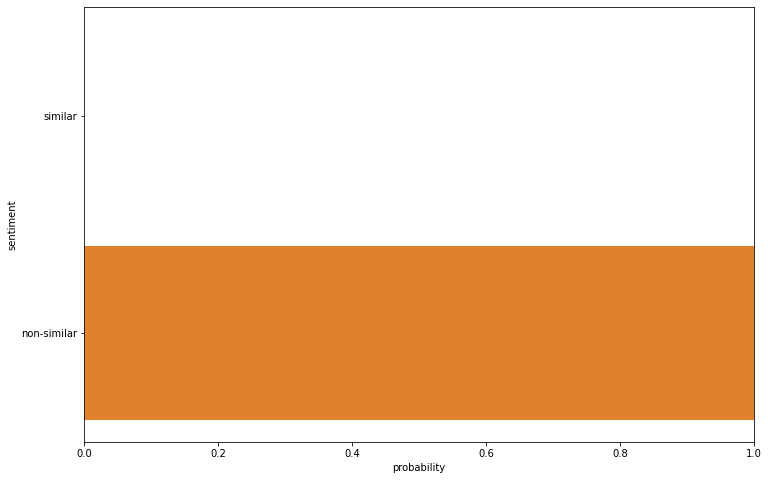

In [28]:
pred_df = pd.DataFrame({
  'class_names': ['similar', 'non-similar'],
  'values': y_pred_probs[0]
})

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);